# PRÁCTICA 1: MODELOS DE DIFUSION Y MECANISMOS DE ATENCIÓN

En esta práctica veremos como podemos definir una de las arquitecturas más novedosas en el campo de las redes neuronales: los **__modelos de difusión**__.

En esencia, un modelo de difusión aprende a generar datos similares a una entrada a partir de imágenes con puro ruido. Este tipo de modelos se han vuelto muy populares en la generación de imágenes como DALL-E de OpenAI.

Los principales conceptos que cubriremos con esta práctica son los siguientes:
 - Definir modelos de difusión
 - Arquitectura U-NET
 - Mecanismos de atención basados en __visual transformers__

Antes de comenzar con el modelo, vamos a importar las librerías que necesitaremos:

In [1]:
!jupyter nbextension enable --py widgetsnbextension

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import os
from typing import List
import random
import math
import shutil

# Librerías de PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Una librería muy util para ajustar los tamaños de nuestros tensores
from einops import rearrange

# Torch vision para descargar y preprocesar el conjunto de datos que usaremos para entrenar la red
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Herramientas adicionales para la visualización de los datos y resultados
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.optim as optim
import numpy as np

A diferencia de la **Práctica 4**, aquí veremos como usar las funciones de compilación de código en __PyTorch__ para mejorar la eficiencia de nuestras redes. En primer lugar, configuraremos __PyTorch__ para que pueda optimizar al máximo las operaciones con el tipo de dato ``Float32``:

In [3]:
torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

Durante esta práctica usaremos de nuevo el conjunto de datos `FashionMNIST` para entrenar la red. Comenzaremos por descargar y generar el `DataLoader` para poder enviar datos a la red de manera eficiente:

In [4]:
train_dataset = datasets.FashionMNIST("./MNIST_DATA", train=True, download=True,transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4)

Inspección de los datos de entrenamiento: 
Tamaño del lote:  torch.Size([64, 1, 28, 28])


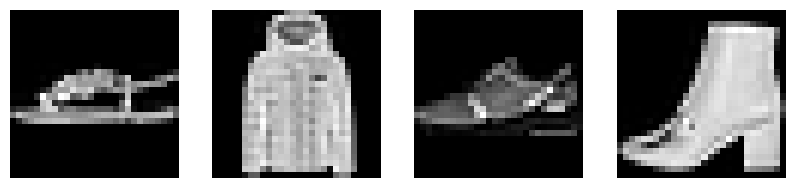

In [5]:
print("Inspección de los datos de entrenamiento: ")
for _, data in enumerate(train_loader):
    print("Tamaño del lote: ", data[0].shape)
    fig, ax = plt.subplots(1, 4, figsize=(10, 4))

    for i in range(4):
        # Ture 3D tensor to 2D tensor due to image's single channel
        ax[i].imshow(data[0][i].squeeze(), cmap="gray")
        ax[i].axis("off")
    plt.show()
    # And don't forget to break
    break

Antes de definir nuestra red, vamos a generar un embedding sinusoidal. Este tipo de embeddings permiten transmitir el concepto de "secuencia" a nuestros datos:

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/0*DEZ4oDAZm0RCOPDb.png" width=500, heigh=500 />

En nuestro caso, los usaremos para definir diferentes momentos en el tiempo: cuando nuestro tiempo sea igual a 0, tendremos imágenes compuestas completamente por ruido. A medida que el tiempo avance, nuestras imágenes iran perdiendo ruido y ganando señal hasta llegar a una imagen limpia del objeto de interés. Por lo tanto, este concepto de tiempo no deja de ser una secuencia de pasos, teniendo cada uno una cantidad de ruido menor.


In [6]:
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings

    def forward(self, x, t):
        embeds = self.embeddings[t].to(x.device)
        return embeds[:, :, None, None]

Una vez definidos nuestro embedding con sentido de secuencia, podemos comenzar a instanciar nuestra U-NET. En primer lugar, comenzaremos por definir el bloque esencial que compone este tipo de redes: un conjunto de capas convolucionales con conexiones residuales:

In [7]:
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)  # Esta capa normaliza los canales dividiendolas previamente en pequeños grupos
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)  # Esta capa normaliza los canales dividiendolas previamente en pequeños grupos
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :, :]  # Embeddings vendrá definido por SinusoidalEmbeddings en un "momento" determinado de la secuencia de tiempo
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

<img src="https://api.wandb.ai/files/wandb_fc/images/projects/605819/472b8f50.png" width=500, heigh=500 />


Una vez definido el bloque esencial de nuezstra U-NET, podemos pasar a definir cada capa de nuestra red neuronal. Estas capas estarán compuestas por dos bloques residuales (previamente definidos), una capa de atención basada en transformadores visuales, y una capa de convolución/convolución transpuesta (esto dependerá de si esta capa se encuentra en la primera o en la segunda mitad de nuestra U-NET tal y como veremos más adelante):

In [8]:
class UnetLayer(nn.Module):
    def __init__(self,
            upscale: bool,
            attention: bool,
            num_groups: int,
            dropout_prob: float,
            num_heads: int,
            C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        if upscale:
            self.conv = nn.ConvTranspose2d(C, C // 2, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = nn.Conv2d(C, C * 2, kernel_size=3, stride=2, padding=1)
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

Para completar la capa de nuestra U-NET, tenemos que definir la capa con mecanismo de atención. Para más información sobre el mecanismo de funcionamiento de esta capa, es recomendable dirigirse a las diapositivas teóricas del curso.

A modo de resumen, la capa de atención se basa en calcular una sería de matrices entrenables a partir de los inputs:
 - Capa **Q** (Queries): Representa el conjunto de elementos a partir de los cuales calcularemos la atención.
 - Capa **K** (Keys): Una capa que contiene "identificadores" para un determinado valor. Se usa en conjunto con la capa **Q** para determinar cuanta atención hay que prestar a cada valor.
 - Capa **V** (Values): Esta capa contiene los valores con información (es decir, nuestro input) a los que aplicaremos la atención previamente calculada.

Nuestra capa de atención calculará las matrices Q, K y V a partir de los inputs de la capa, aplicando una capa densa (que se puede entender como una proyección de los inputs en base a una matriz entrenable). Previamente a este cálculo, redimensionaremos nuestro input fusionando las dimensiones espaciales de la imagen (generando así una secuencia 1D sobre la que aplicar la atención) y dejando la capa de canales como una capa auxiliar para calcular las features necesarias para derivar las matrices Q, K y V.

Una vez calculadas estas matrices, calcularemos la atención de acuerdo a la fórmula:

<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*sXEtwjKCACQ6yfW5T8UolQ.png" width=500, heigh=500 />


In [9]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads: int, dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C * 3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q, k, v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q, k, v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')

A partir de las capas previamente definidas, podemos construir nuestra U-Net. Una arquitectura U-NET se basa en una serie de capas simétricas de submuestreado y escalado con conexiones residuales, de tal manera que la salida de la red tenga el mismo tamaño que los datos de entrada. Nuestra clase incluirá un conjunto de listas que nos permitirán definir tanto el número de capas de nuestra U-Net como el encrustamiento de capas de atención solo en determinadas capas.

In [10]:
class UNET(nn.Module):
    def __init__(self,
            Channels: List = [64, 128, 256, 512, 512, 384],
            Attentions: List = [False, True, False, False, False, True],
            Upscales: List = [False, False, False, True, True, True],
            num_groups: int = 32,
            dropout_prob: float = 0.1,
            num_heads: int = 8,
            input_channels: int = 1,
            output_channels: int = 1,
            time_steps: int = 1000):
        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1] // 2)+Channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels // 2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels // 2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)
        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x = torch.concat((layer(x, embeddings)[0], residuals[self.num_layers-i-1]), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

En este punto, tenemos nuestra red completamente definida y lista para ser entrenada. Sin embargo, aún no tenemos un método para corromper nuestras imágenes con diferentes niveles de ruido dependiendo del momento en el "tiempo" en el que se encuentren nuestras imágenes. Recordemos que este "momento en el tiempo" hacer referencia al nivel de ruido en las imágenes (siendo t=0 el momento en el que solo hay ruido y t=N el momento en el que nuestra imagen no tiene ruido).

Para ello, vamos a definir un ``Scheduler``, el cual nos permitirá recuperar los parámetros necesarios para recuperar el nivel de ruido que corromperá a la imagen en cada momento en el tiempo:

In [11]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

Como se puede observar en la celda anterior, además de nuestro scheduler (``DDPM_Scheduler``) también se incluye la función ``set_seed``. Por norma general, esta función solo la usaremos en el caso de querer reproducir de manera exacta los resultados de un entrenamiento determinado.

Es importante recordar en este momento que el proceso de entrenamiento de una red es estocástico, lo que da lugar a resultados con cierta variabilidad en cada entrenamiento. Esto se debe a la presencia de ciertos números aleatorios que son diferentes en cada ejecución. El método ``set_seed`` fuerza a que estos números aleatorios sean los mismos en cada ejecución, permitiendo así reproducir los resultados mientras comprobamos que la red funciona correctamente. Una vez hagamos estas comprobaciones, es importante dejar de usar el método para poder tener variabilidad en nuestros entrenamientos.

Una vez definidos todos los componentes necesarios para entrenar la red, podemos proceder con la instanciación del loop de entrenamiento. En ese caso, lo encapsularemos dentro de una función para que sea más sencillo de ejecutar en diferentes scripts.

Nuestra función de entrenamiento recibirá como input los principales hiperparámetros a controlar para asegurar que el entrenamiento se ajusta a nuestro requirimientos de hardware. Estos parámetros incluyen:

- Número de "momentos en el tiempo" (**num_time_steps**): Permite determinar cuantos niveles de ruido habrá entre el primer momento en el tiempo (imagen formada solo por ruido) y el tiempo final (imagen sin ruido)
- Número de epochs (**num_epochs**): Permite modificar el número de veces que se recorre el conjunto de entrenamiento
- **seed**: Este parámetro se usa para controlar la función ``set_seed``, permitiendo así determinar si nuestro entranamiento es estocástico o lo fijamos para que de siempre el mismo resultado. El valor por defecto indica que el proceso será estocástico.
- Archivo de punto de guardado (**checkpoint_path**): Permite dar el path a un archivo dónde iremos guardando el estado de la red a medida que el entrenamiento avanza. Esto es muy útil sobre todo cuando el proceso de entrenamiento es largo o queremos analizar el estado de la red en algún punto intermedio del entrenamiento, permitiéndonos recargar el estado de la red en ese punto para hacer inferencia o continuar el entrenamiento desde ese punto.

Adicionalmente, vamos a aprovechar la función de compilación de __PyTorch__ para mejorar la eficiencia de nuestra red neuronal y reducir el tiempo de entrenamiento. Para ello, usaremos la función ``torch.compile``, pasándole como argumento nuestro modelo UNET instanciado. Esta función hará una ejecución "fantasma" del código de nuestra red con el objetivo de compilar y optimizar el mismo en tiempo real (lo que se conoce como __Just In Time compilation - JIT__). Este paso tarda algo de tiempo en realizarse, pero permite que las llamadas a la red sean mucho más rápidas.

Esto sobre todo es útil cuando necesitamos ejecutar nuestra red varias veces dentro de nuestro programa (por ejemplo, durante el loop de entrenamiento o en la inferencia), ya que el tiempo que se pierde compilando y optimizando será inferior siempre al de la ejecución total sin compilar.

Es importante tener en cuenta que la función ``torch.compile`` puede usarse tanto en módulos de PyTorch (``nn.Module`` como nuestra red) o en funciones estándar. También podemos incluir el decorador ``@torch.compile`` encima la de declaración de nuestro módulo o función para conseguir el mismo efecto.

Tanto la función ``torch.compile`` como el decorador ``@torch.compile`` pueden recibir el argumento adicional ``mode`` para controlar el nivel de optimización:

- **default**: Este modo es la opción por defecto. Reduce el tiempo de optimización a costa de obtener un código compilado menos eficiente.
- **reduce-overhead**: Aumenta el tiempo de compilación y el uso de memoria para generar un código más eficiente que con la opción **default**.
- **max-autotune**: Compila usando una cantidad de tiempo y memoria mayor que **reduce-overhead** para obtener el código compilado más optimizado posible.

Aunque es posible elegir entre estas opciones, es importante tener en cuenta que no siempre darán un resultado satisfactorio. Si nuestro código no está preparado para la opción **max-autotune**, __PyTorch__ optará por usar la opción **default** independientemente del argumento **mode**.

Como norma general, la compilación en PyTorch suele dar mejores resultados (y ser compatible con cualquiera de los modos anteriores) si nuestros tensores tienen un tamaño estático. Esto quiere decir que, quitando las dimensiones de batch, el resto de dimensiones de un determinado tensor se mantendrán siempre fijas a lo largo de la ejecución. En el caso de no ser así, aún sería posible usar ``torch.compile`` aunque el nivel de optimización automático será menor.

In [12]:
def train(batch_size: int=64,
          num_time_steps: int=1000,
          num_epochs: int=15,
          seed: int=-1,
          lr=2e-5,
          checkpoint_path: str=None):
    set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)

    train_dataset = datasets.FashionMNIST("./MNIST_DATA", train=True, download=True,transform=transforms.ToTensor())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    model = UNET()
    model_compiled = torch.compile(model)
    model_compiled = model_compiled.cuda()

    optimizer = optim.Adam(model_compiled.parameters(), lr=lr)
    if checkpoint_path is not None and os.path.isdir(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    elif checkpoint_path is not None and not os.path.isdir(checkpoint_path):
        os.makedirs(checkpoint_path)
    criterion = nn.MSELoss(reduction='mean')

    for i in range(num_epochs):
        total_loss = 0
        for bidx, (x,_) in enumerate(tqdm(train_loader, desc=f"Epoch {i + 1}/{num_epochs}")):
            x = x.cuda()
            x = F.pad(x, (2, 2, 2, 2))
            t = torch.randint(0, num_time_steps, (batch_size,))
            e = torch.randn_like(x, requires_grad=False)
            a = scheduler.alpha[t].view(batch_size, 1, 1, 1).cuda()
            x = (torch.sqrt(a) * x) + (torch.sqrt(1 - a) * e)
            output = model_compiled(x, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f'Epoch {i + 1} | Loss {total_loss / (60000 / batch_size):.5f}')

    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    if checkpoint_path is not None:
        torch.save(checkpoint, os.path.join(checkpoint_path, "checkpoint.pth"))

El siguiente paso consiste en entrenar nuestra red usando la función anterior:

In [13]:
    if os.path.isdir(os.path.join('checkpoints')):
        shutil.rmtree(os.path.join('checkpoints'))
    train(checkpoint_path=os.path.join('checkpoints', 'ddpm_checkpoint'), lr=1e-4, num_epochs=5)

Epoch 1/5: 100%|██████████| 937/937 [02:53<00:00,  5.40it/s]


Epoch 1 | Loss 0.07154


Epoch 2/5: 100%|██████████| 937/937 [02:25<00:00,  6.46it/s]


Epoch 2 | Loss 0.03325


Epoch 3/5: 100%|██████████| 937/937 [02:24<00:00,  6.50it/s]


Epoch 3 | Loss 0.02808


Epoch 4/5: 100%|██████████| 937/937 [02:25<00:00,  6.44it/s]


Epoch 4 | Loss 0.02537


Epoch 5/5: 100%|██████████| 937/937 [02:25<00:00,  6.46it/s]


Epoch 5 | Loss 0.02483


Una vez hayamos entrenado la red, podemos aprovechar nuestro archivo ``checkpoint.pth`` para recargarla y hacer inferencia de nuestro conjunto de datos para así comprobar si la red es capaz de regenerar nuestras imágenes a partir de puro ruido. Para ello, definiremos en primer lugar una función para representar las imágenes que se generen desde la red.

##### IMPORTANTE A TENER EN CUENTA

Dado que en esta práctica estamos usando las funcionalidades de compilación de __PyTorch__, es importante mantener siempre la red original sin compilar en una variable a parte. Tanto la red compilada como la no compilada comparten parámetros, pero los de la red compilada suelen tener un nombre asignado ligeramente diferente al de la red original. Como se puede ver en la función de entrenamiento, usamos la red compilada durante el entrenamiento, pero guardamos los parámetros de la red (en el archivo ``checkpoint.pth``) usando la red sin compilar. De esta manera, evitamos la necesidad de tener que precompilar una nueva instancia de la red antes de cargar los pesos, ahorrándo tiempo y simplificando la recarga de la red.

In [14]:
def display_reverse(images: List, times: List=None, save_gif=True):
    if times is not None:
        t = 0

    if save_gif:
        frames = []
        fig, ax = plt.subplots()
        for i in range(len(images)):
            x = images[i].squeeze(0)
            x = rearrange(x, 'c h w -> h w c')
            x = x.numpy()
            im = ax.imshow(x, animated=True, cmap="Grays_r")
            if i == 0:
                ax.imshow(x, cmap="Grays_r")
            if times is not None:
                ax.set_title("Time: " + str(times[t]))
                t += 1
            ax.axis('off')
            fig.tight_layout()
            frames.append([im])
        ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True,
                                        repeat_delay=1000)
        writer = animation.PillowWriter(fps=2, bitrate=1800)
        ani.save(f"diffusion_model_example.gif", writer=writer)
    else:
        fig, axes = plt.subplots(1, len(images), figsize=(len(images), 1))
        for i, ax in enumerate(axes.flat):
            x = images[i].squeeze(0)
            x = rearrange(x, 'c h w -> h w c')
            x = x.numpy()
            ax.imshow(x, cmap="Grays")
            if times is not None:
                ax.set_title("Time: " + str(times[t]))
                t += 1
            ax.axis('off')
        fig.tight_layout()
        plt.show()

A continuación definiremos una nueva función que nos permitirá hacer inferencia con la red. Esta función aprovechará el archivo ``checkpoint.pth`` para recargar el estado de la red y así poder utilizarla para predecir imágenes a partir de puro ruido.

Para ello, aprovecharemos nuestro ``DDPM_Scheduler`` para generar los parámetros que necesitaremos para generar los diferentes niveles de ruido. De manera intuitiva, el proceso de inferencia es exactamente igual al de entrenamiento pero en sentido opuesto: empezaremos con imágenes de ruido y progresivamente la red irá disminuyendo el ruido hasta conseguir una imagen única que se parezca a las imágenes de entrenamiento. Cada vez que generemos una nueva imagen de ruido, obtendremos una imagen única diferente.

In [15]:
def inference(checkpoint_path: str=None,
              num_time_steps: int=1000):
    checkpoint = torch.load(os.path.join(checkpoint_path, "checkpoint.pth"))
    model = UNET()
    # model = torch.compile(model, mode="reduce-overhead")  # En caso de que se quiera también compilar el modelo para inferencia
    model = model.cuda()
    model.load_state_dict(checkpoint['weights'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0,15,50,100,200,300,400,550,700,999]
    images = []

    with torch.no_grad():
        model = model.eval()
        for i in range(1):
            z = torch.randn(1, 1, 32, 32)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t] / ( (torch.sqrt( 1 - scheduler.alpha[t])) * (torch.sqrt(1 - scheduler.beta[t]))))
                z = (1 / (torch.sqrt(1 - scheduler.beta[t]))) * z - (temp * model(z.cuda(), t).cpu())
                if t[0] in times:
                    images.append(z)
                e = torch.randn(1, 1, 32, 32)
                z = z + (e * torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0] / ((torch.sqrt(1 - scheduler.alpha[0])) * (torch.sqrt(1 - scheduler.beta[0])))
            x = (1 / (torch.sqrt(1 - scheduler.beta[0]))) * z - (temp * model(z.cuda(), [0]).cpu())

            images.append(x)
            display_reverse(images, times=list(reversed(times)))
            images = []

A continuación, probaremos la capacidad de inferencia de la red:

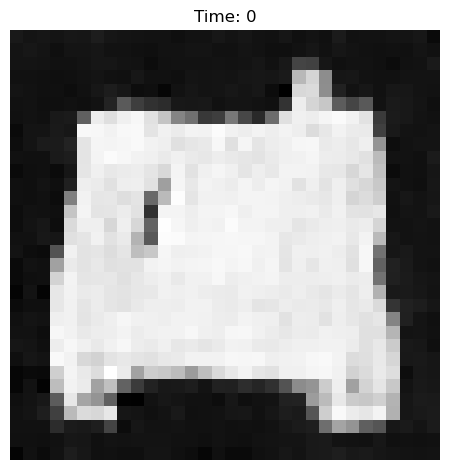

In [16]:
inference(os.path.join('checkpoints', 'ddpm_checkpoint'))

<img src="diffusion_model_example.gif" width=500, heigh=500 />